<div class="alert alert-block alert-danger">

For this practice notebook, please download the notebook and run it on Google Colab, as it requires GPU access. As of September 19, 2025, our GPU infrastructure is still under development. We will notify you once GPU-enabled containers become available.

</div>

# Tokens and Token Embeddings

This notebook guides us through the foundations of NLP, emphasizing how **tokens**—the basic units of text—bridge human language and machine computation. We'll learn how **token embeddings** provide numerical representations that let models "understand" meaning. Step by step, we will experiment and see how these concepts fuel advanced applications, including text generation and recommendations.

## Why Tokens and Embeddings Matter

- **Tokens** split sentences into manageable pieces (like words or subwords), making it possible for models to process and analyze text.
- **Token embeddings** capture meaning in a dense vector format, powering everything from search engines to recommendation systems.
- By walking through each part of the LLM pipeline, we can better appreciate *how data science leverages these tools for real-world tasks*.


## Downloading and Running an LLM

Our journey begins by loading the *Phi-3-mini* causal language model. We use our own machine's resources (preferably a GPU) for fast and effective text generation. This helps us see the whole flow: **text → tokens → model computation → output**.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load the causal language model for text generation.
# The model is loaded onto the GPU for faster inference.
# 'torch_dtype="auto"' automatically selects the best tensor type for your hardware.
# 'trust_remote_code=False' disables execution of custom code from the model repo for security.
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=False,
)

# Load the corresponding tokenizer for preprocessing and decoding text.
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

- **Why do we care?**
    - Loading both the model and tokenizer sets the stage for all text-to-number transformations.
    - We can now generate responses to any prompt, giving us hands-on experience with core NLP mechanics.


## Understanding Tokenization

Let's see how our model handles real text. We create a prompt related to the University of Missouri, typical for administrative and academic tasks. We want to:

- Tokenize the input,
- Understand how the model splits words,
- Learn why efficient tokenization enables handling large vocabularies within hardware limits.

In [ ]:
# Define the prompt for the language model: an email apologizing for a delayed research report submission
prompt = (
  "Write an email apologizing to the University of Missouri administration for the delay "
  "in submitting the research report. Explain the reasons and assure timely submission in the future.<|assistant|>"
)

# Tokenize the input prompt and move the token IDs to the GPU for faster processing
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")

# Generate a response from the model, limiting the output to 500 new tokens
generation_output = model.generate(
  input_ids=input_ids,
  max_new_tokens=500
)

# Decode the generated token IDs back to text and print the result
print(tokenizer.decode(generation_output[0]))

Write an email apologizing to the University of Missouri administration for the delay in submitting the research report. Explain the reasons and assure timely submission in the future.<|assistant|> Subject: Apology for Delayed Submission of Research Report


Dear University of Missouri Administration,


I hope this message finds you well. I am writing to sincerely apologize for the delay in submitting the research report that was due on April 15, 2023.


Unfortunately, unforeseen circumstances arose that significantly impacted my ability to complete the report on time. Specifically, I encountered a critical technical issue with my computer, which resulted in the loss of a substantial portion of my work. Additionally, I was unexpectedly called away for a family emergency, which further hindered my progress.


I understand the importance of adhering to deadlines, especially in an academic setting, and I deeply regret any inconvenience this delay may have caused. Please rest assured that 

**What is Happening Here?**


- Our model processes **token IDs**, not words. For words it hasn't seen before, it breaks them into recognizable subword units (e.g., "apologizing" → "apolog" + "izing").
- This **subword tokenization** reduces the unknown words problem and allows representation of any string using a fixed vocabulary.
- The generated text can elegantly complete contextual tasks we face in academia and research.

In [ ]:
# Print the token IDs generated from the input prompt after tokenization
print(input_ids)

tensor([[14350,   385,  4876, 27746,  5281,   304,   278,  3014,   310, 19171,
         17517,   363,   278,  9055,   297, 11834,  5367,   278,  5925,  3461,
         29889, 12027,  7420,   278,  9590,   322,  1223,   545,  5335,   873,
         29240,   297,   278,  5434, 29889, 32001]], device='cuda:0')


**Inspecting Tokens and Decoding**

We already printed the list of **token IDs** for our University of Missouri-themed prompt. To deepen our understanding, we decoded each token ID, observing how the tokenizer splits words into subwords or entire tokens. Let's reinforce why this matters:

- **Token IDs** are the **fundamental input** for all modern language models. Every prompt, sentence, or document must be mapped to a series of integer IDs, with each representing a chunk of text defined by the tokenizer's vocabulary.
- We noted earlier that "apologizing" became "apolog" + "izing"—a result of **subword tokenization**. This allows models to handle unknown words, rare terms, and even code or emojis, by breaking down language into consistent, manageable units.

In [ ]:
# Iterate over each token ID in the input prompt
for id in input_ids[0]:
   # Decode the token ID back to its corresponding text and print it
   print(tokenizer.decode(id))

Write
an
email
apolog
izing
to
the
University
of
Missouri
administration
for
the
delay
in
subm
itting
the
research
report
.
Exp
lain
the
reasons
and
ass
ure
tim
ely
submission
in
the
future
.
<|assistant|>


**What we see:**

- Each output is a token or subword.
- Special tokens (like `<|assistant|>`) mark prompt boundaries for chat-oriented models.
- Common words or suffixes/affixes often repeat across examples.

In [ ]:
# 'generation_output' contains the token IDs generated by the language model in response to the input prompt.
# These token IDs can be decoded back to text using the tokenizer.
generation_output

tensor([[14350,   385,  4876, 27746,  5281,   304,   278,  3014,   310, 19171,
         17517,   363,   278,  9055,   297, 11834,  5367,   278,  5925,  3461,
         29889, 12027,  7420,   278,  9590,   322,  1223,   545,  5335,   873,
         29240,   297,   278,  5434, 29889, 32001,  3323,   622, 29901,  6225,
          3002,   363,  5556,   388,   287,  3323,  6737,   310, 10550, 13969,
            13,    13,    13, 29928,   799,  3014,   310, 19171, 23303, 29892,
            13,    13,    13, 29902,  4966,   445,  2643, 14061,   366,  1532,
         29889,   306,   626,  5007,   304,  4457,  2265,   873, 27746,   675,
           363,   278,  9055,   297, 11834,  5367,   278,  5925,  3461,   393,
           471,  2861,   373,  3786, 29871, 29896, 29945, 29892, 29871, 29906,
         29900, 29906, 29941, 29889,    13,    13,    13,  2525,  7524, 29892,
           443,  1454,   968,   264, 14209, 28811,   393, 16951, 10879,   287,
           590, 11509,   304,  4866,   278,  3461,  

In [ ]:
# Decode and print the token with ID 3323 using the tokenizer
print(tokenizer.decode(3323))

# Decode and print the token with ID 622 using the tokenizer
print(tokenizer.decode(622))

# Decode and print the sequence of tokens [3323, 622] as a string
print(tokenizer.decode([3323, 622]))

# Decode and print the token with ID 29901 using the tokenizer
print(tokenizer.decode(29901))

Sub
ject
Subject
:


# Comparing Trained LLM Tokenizers

Tokenization varies by model; we compare how different tokenizers (e.g., BERT's WordPiece vs. GPT-2's Byte-Pair Encoding) handle a sample text with university terms, emojis, and math. This highlights trade-offs in handling diverse inputs, logically leading to embeddings where token quality affects meaning capture. Colors aid visualization for educational clarity.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# List of RGB color codes for highlighting tokens in the output
colors_list = [
    '102;194;165', '252;141;98', '141;160;203',
    '231;138;195', '166;216;84', '255;217;47'
]

def show_tokens(sentence, tokenizer_name):
    # Load the specified tokenizer from Hugging Face
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    # Tokenize the input sentence and get token IDs
    token_ids = tokenizer(sentence).input_ids
    # Iterate over each token ID and print the decoded token with colored background
    for idx, t in enumerate(token_ids):
        print(
            # ANSI escape code for colored background using RGB values from colors_list
            f'\x1b[0;30;48;2;{colors_list[idx % len(colors_list)]}m' +
            tokenizer.decode(t) +
            '\x1b[0m',
            end=' '
        )

In [ ]:
# Define a sample text containing university-related phrases, emojis, code-like syntax, and a math expression.
text = """
University of Missouri and CAMPUS LIFE
🎓 Mizzou Tigers
show_tokens False None elif == >= else: two tabs:"    " Three tabs: "       "
12.0*50=600
"""

In [ ]:
# Visualize how the 'bert-base-uncased' tokenizer splits the sample text into tokens.
# Each token is highlighted with a different color for clarity.
show_tokens(text, "bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

[CLS] university of missouri and campus life [UNK] mi ##zzo ##u tigers show _ token ##s false none eli ##f = = > = else : two tab ##s : " " three tab ##s : " " 12 . 0 * 50 = 600 [SEP] 

In [ ]:
# Visualize how the 'gpt2' tokenizer splits the sample text into tokens.
# Each token is highlighted with a different color for clarity.
show_tokens(text, "gpt2")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


 University  of  Missouri  and  C AMP US  LIFE 
 � � �  M izz ou  Tigers 
 show _ t ok ens  False  None  el if  ==  >=  else :  two  tabs :"        "  Three  tabs :  "              " 
 12 . 0 * 50 = 600 
 

In [ ]:
# Visualize how the 'google/flan-t5-small' tokenizer splits the sample text into tokens.
# Each token is highlighted with a different color for clarity.
show_tokens(text, "google/flan-t5-small")

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

University of Missouri and C AMP US LI FE  <unk> Mi zzo u Tiger s show _ to ken s Fal s e None  e l if = = > = else : two tab s : " " Three tab s : " " 12. 0 * 50 = 600  </s> 

In [ ]:
# Visualize how the 'Xenova/gpt-4' tokenizer (Hugging Face implementation, similar to official tiktoken) splits the sample text into tokens.
# Each token is highlighted with a different color for clarity.
show_tokens(text, "Xenova/gpt-4")

tokenizer_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]


 University  of  Missouri  and  C AMP US  LIFE 
 � � �  M izz ou  Tigers 
 show _tokens  False  None  elif  ==  >=  else :  two  tabs :"      "  Three  tabs :  "         "
 12 . 0 * 50 = 600 
 

In [ ]:
# Visualize how the 'bigcode/starcoder2-15b' tokenizer splits the sample text into tokens.
# Note: You need to request access to this model on Hugging Face before you can use its tokenizer.
show_tokens(text, "bigcode/starcoder2-15b")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]


 University  of  M iss our i  and  C AMP US  L IF E 
 � � �  M izz ou  T ig ers 
 show _ tokens  False  None  elif  ==  >=  else :  two  tabs :"      "  Three  tabs :  "         " 
 1 2 . 0 * 5 0 = 6 0 0 
 

In [ ]:
# Visualize how the 'facebook/galactica-1.3b' tokenizer splits the sample text into tokens.
# Each token is highlighted with a different color for clarity.
show_tokens(text, "facebook/galactica-1.3b")

tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.00 [00:00<?, ?B/s]


 University  of  Missouri  and  CA MP US  LIF E 
 � � � �  M izz ou  Tig ers 
 show _ tokens  False  None  elif   ==   > =  else :  two  t abs : "      "  Three  t abs :   "         " 
 1 2 . 0 * 5 0 = 6 0 0 
 

In [ ]:
# Visualize how the 'microsoft/Phi-3-mini-4k-instruct' tokenizer splits the sample text into tokens.
# Each token is highlighted with a different color for clarity.
show_tokens(text, "microsoft/Phi-3-mini-4k-instruct")

 
 Univers ity of Missouri and CA MP US L IF E 
 � � � � M izz ou Tig ers 
 show _ to kens False None elif == >= else : two tabs :"    " Three tabs : "       " 
 1 2 . 0 * 5 0 = 6 0 0 
 

**Comparing Tokenizer Outputs Across Models**

Different LLMs use **different tokenization algorithms**:


| Model | Tokenizer Type | Notes |
| :-- | :-- | :-- |
| **BERT (uncased)** | WordPiece | Breaks rare/unknown words into known sub-word units |
| **GPT-2** | Byte-Pair Encoding | Efficient, works at byte level, can handle emojis, code, multilingual |
| **T5/Flan-T5** | SentencePiece | Enables training on raw text, often better at multilingual |
| **Llama/Phi-3** | LlamaTokenizer | Sub-word, tailored for efficient context handling |

We used a **color-highlighting function** to visualize how different tokenizers split a university-themed, emoji-rich, and math-laced sample. This **hands-on visualization** reveals:

- Not all models handle emojis or out-of-vocabulary characters the same way.
- Spacing, casing, and uncommon combos (like "CAMPUS" or "12.0*50=600") can yield very different token splits.
- Some models (e.g., BERT's `[UNK]`) revert to unknown tokens, while others (e.g., GPT-2, Phi-3) produce more granular splits.

From an educational standpoint, this **vividly illustrates** why tokenization is so foundational—the way a tokenizer slices text directly influences the vocabulary coverage, efficiency, and downstream model "understanding."

In [ ]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

models = [
    ("Phi-3", "microsoft/Phi-3-mini-4k-instruct"),
    ("Galactica", "facebook/galactica-1.3b"),
    ("StarCoder2", "bigcode/starcoder2-15b"),
    ("GPT-4 (Xenova)", "Xenova/gpt-4"),
    ("T5/Flan-T5", "google/flan-t5-small"),
    ("GPT-2", "gpt2"),
    ("BERT (uncased)", "bert-base-uncased")
]

text = """
University of Missouri and CAMPUS LIFE
🎓 Mizzou Tigers
show_tokens False None elif == >= else: two tabs:"    " Three tabs: "       "
12.0*50=600
"""

token_counts = []
for model_name, tokenizer_name in models:
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    tokens = tokenizer(text).input_ids
    token_counts.append((model_name, len(tokens)))

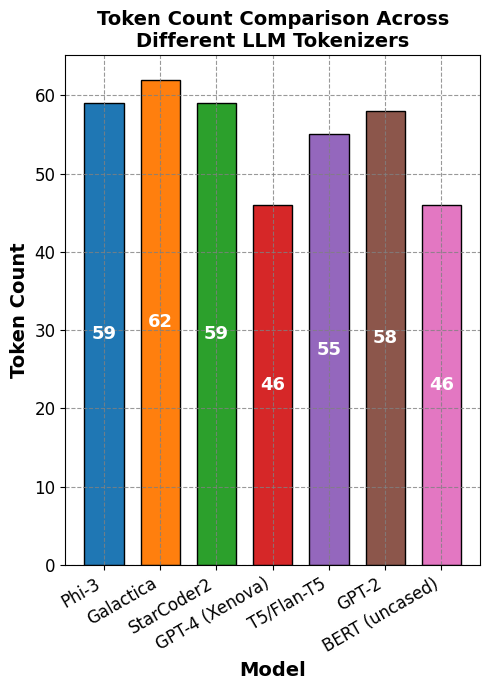

In [ ]:
import matplotlib.pyplot as plt
plt.style.use(
    "https://raw.githubusercontent.com/HatefDastour/matplotlib_custom_style/main/custom_style.mplstyle")
labels, counts = zip(*token_counts)

# Generate colors: you can also use your own palette
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(len(labels))]

# Number of bars and positions
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(5, 7))

# Make vertical bars
bars = ax.bar(x, counts, color=colors, width=0.7, ec='k', lw=1)

# Set x-axis labels
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30, ha="right")

# Set axis labels and title
ax.set_ylabel("Token Count", fontweight="bold")
ax.set_xlabel("Model", fontweight="bold")
ax.set_title("Token Count Comparison Across\nDifferent LLM Tokenizers")

# Add token count at the middle-top of each bar
ax.bar_label(
    bars, labels=[str(c) for c in counts],
    label_type='center', color='white', fontsize=13, weight='bold'
)

plt.tight_layout()

# Contextualized Word Embeddings From a Language Model (Like BERT)

Once we have the tokenized text, **contextualized embeddings** represent each token *in its specific sentence context*. Unlike static word vectors, these:

- Are *dynamically calculated* based on the full sentence,
- Adjust the representation of each word depending on what's around it (e.g., "bank" in "river bank" vs "money bank").


In [ ]:
from transformers import AutoModel, AutoTokenizer

# Load the tokenizer for the DeBERTa model (used for splitting text into tokens)
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")

# Load the DeBERTa language model (returns contextualized embeddings for each token)
model = AutoModel.from_pretrained("microsoft/deberta-v3-xsmall")

# Tokenize the input sentence and convert it to PyTorch tensors
tokens = tokenizer('Hello world', return_tensors='pt')

# Pass the tokenized input through the model to obtain contextualized embeddings
# The output[0] contains the embeddings for each token in the input sentence
output = model(**tokens)[0]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/241M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

In [ ]:
# 'output' contains the contextualized embeddings for each token in the input sentence.
# The shape of 'output' indicates (batch_size, sequence_length, embedding_dimension).
output.shape

torch.Size([1, 4, 384])

In [ ]:
for token in tokens['input_ids'][0]:
    print(tokenizer.decode(token))

[CLS]
Hello
 world
[SEP]


**Why It All Connects**

- **Tokenization**: Fundamental to how we turn any linguistic artifact into numbers, which the model processes.
- **Token IDs**: Direct input to the model, and show "what" the model sees (emphasizing why good tokenization coverage is crucial).
- **Embeddings**: Give us a *meaning-rich, context-aware representation* of language, enabling advanced NLP tasks such as semantic search, classification, clustering, or recommendations.
- **Different tokenizers**: Affect both preprocessing and ultimately the *quality* of embeddings—so comparing them empirically deepens our intuition.

In [ ]:
output

tensor([[[-3.4816,  0.0861, -0.1819,  ..., -0.0612, -0.3911,  0.3017],
         [ 0.1898,  0.3208, -0.2315,  ...,  0.3714,  0.2478,  0.8048],
         [ 0.2071,  0.5036, -0.0485,  ...,  1.2175, -0.2292,  0.8582],
         [-3.4278,  0.0645, -0.1427,  ...,  0.0658, -0.4367,  0.3834]]],
       grad_fn=<NativeLayerNormBackward0>)

# Text Embeddings (For Sentences and Whole Documents)

To extend our understanding from tokens to **sentence** and **document-level meaning**, we use **transformer embedding models** that map whole texts (not just single words) into fixed-length, high-dimensional vectors. These **text embeddings** are the backbone for many modern NLP applications—ranging from search and clustering to recommendations and data mining.

## Sentence-Level Embeddings: How and Why

We used the [**Sentence Transformers**](https://www.sbert.net/) library, which offers state-of-the-art models for producing robust **sentence and document embeddings**. Here, the `all-mpnet-base-v2` model converts a full sentence—

> *"The Data Science and Analytics Program at the University of Missouri in Columbia!"*

—into a **768-dimensional vector**:

In [ ]:
from sentence_transformers import SentenceTransformer

# Load model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# Convert text to text embeddings
vector = model.encode("The Data Science and Analytics Program at the University of Missouri in Columbia!")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

**What does this mean?**

- Every sentence (or short document) is mapped into a point in a 768-dimensional semantic space.
- **Similar meanings** (even with different phrasing) are close to each other in this space, regardless of wording or syntactic structure.


## Why These Embeddings Matter

**Text embeddings** enable:

- **Semantic search**: Find related documents, emails, or snippets by meaning—not just keyword overlap.
- **Clustering and classification**: Group or label documents by topic, style, or intent.
- **Recommendations**: Suggest research papers, songs, or learning materials based on concept similarity.

These strengths are crucial for downstream applications in education, research, industry, and more.

## How the Embeddings are Computed

- The sentence is split into tokens, then processed through a multi-layer transformer.
- Unlike word2vec/GloVe—which yield static word vectors—these models capture context and word order.
- For **documents**, a common approach is to encode sentences individually and then combine/embed them (by averaging, pooling, or using a special [CLS] token) to produce a single, holistic vector[^4][^5].
- Models like `all-mpnet-base-v2` and `all-MiniLM-L6-v2` are open-source, fast, and strong performers for general-purpose English tasks

In [ ]:
vector.shape

(768,)